# Differential Evolution (DE)

## 1. Introduction

The content of this introduction is credited to [Differential Evolution from Scratch in Python](https://machinelearningmastery.com/differential-evolution-from-scratch-in-python/) by Stefania Cristina, 2021.

Differential evolution is a heuristic approach for the global optimisation of nonlinear and non-differentiable continuous space functions.

For a minimisation algorithm to be considered practical, it is expected to fulfil five different requirements:

> " (1) Ability to handle non-differentiable, nonlinear and multimodal cost functions. (2) Parallelizability to cope with computation intensive cost functions. (3) Ease of use, i.ei. few control variables to steer the minimization. These variables should also be robust and easy to choose. (4) Good convergence properties, i.e. consistent convergence to the global minimum in consecutive idependent trials."

-- [A Simple and Efficient Heuristic for Global Optimization over Continuous Spaces](https://link.springer.com/article/10.1023/A:1008202821328), 1997. 

The strength of the differential evolution algorithm stems from the fact that it was designed to fulfil all of the above requirements.
        
hese mutations are generated according to a mutation strategy, which follows a general naming convention of DE/x/y/z, where DE stands for Differential Evolution, while x denotes the vector to be mutated, y denotes the number of difference vectors considered for the mutation of x, and z is the type of crossover in use. For instance, the popular strategies:

- DE/rand/1/bin
- DE/best/2/bin

Specify that vector x can either be picked randomly (rand) from the population, or else the vector with the lowest cost (best) is selected; that the number of difference vectors under consideration is either 1 or 2; and that crossover is performed according to independent binomial (bin) experiments. The DE/best/2/bin strategy, in particular, appears to be highly beneficial in improving the diversity of the population if the population size is large enough.

The differential evolution algorithm requires very few parameters to operate, namely the population size, NP, a real and constant scale factor, F ∈ [0, 2], that weights the differential variation during the mutation process, and a crossover rate, CR ∈ [0, 1], that is determined experimentally. This makes the algorithm easy and practical to use.

> "In addition, the canonical DE requires very few control parameters (3 to be precise: the scale factor, the crossover rate and the population size) — a feature that makes it easy to use for the practitioners.


--  [Recent advances in differential evolution: An updated survey](https://link.springer.com/article/10.1007/s10462-009-9137-2), 2016.

Now that we are familiar with the differential evolution algorithm, let’s look at how to implement it from scratch.


## 2. Cost Function

### cross-in-tray
*Characteristics: continuous, non-convex, non-separable, non-differentiable, multimodal, non-random, non-parametric*


This function has multiple local minima with the global minima at $f(x^*) = -2.06261218$ in the search domain $x_i \in [-10, 10], i=1,2$. This function is given as:


$$ f(x) = -0.0001\left( \bigg|sin(x_1)sin(x_2)e^{\big|100-(x_1^2+x_2^2)^{0.5}/\pi\big|}       \bigg| + 1 \right) ^{0.1} $$





In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

In [2]:
# define the cross-in-tray function
def f(x):
    fract1 = np.sin(x[0])*np.sin(x[1])
    fract2 = np.exp(np.abs(100 - np.sqrt(x[0]**2 + x[1]**2)/np.pi))
    return  -0.0001 * (np.abs(fract1*fract2)+1)**0.1 

Now that we visualize the cross-in-tray function.

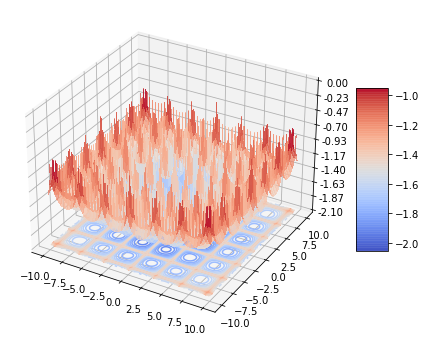

In [3]:
x1 = np.linspace(-10, 10, 1000)
x2 = np.linspace(-10, 10, 1000)
X,Y = np.meshgrid(x1, x2)
Z = f([X,Y])
 
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1, projection='3d')

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False, alpha=0.7)

# Plot the contour.
ax.contour(X, Y, Z, zdir='z', levels=30, offset=np.min(Z), cmap=cm.coolwarm)

# Customize the z axis.
ax.set_zlim(-2.1, 0)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

## 3. Implementing DE from scratch in Python

In [4]:
# import libraries and functions
from numpy.random import rand
from numpy.random import choice
from numpy import asarray
from numpy import clip
from numpy import argmin
from numpy import min
from numpy import around

In [5]:
# define boundary check operation
def check_bounds(mutated, bounds):
    mutated_bound = [clip(mutated[i], bounds[i, 0], bounds[i, 1]) for i in range(len(bounds))]
    return mutated_bound


# define mutation operation
def mutation(x, F):
    return x[0] + F * (x[1] - x[2])


# define crossover operation
def crossover(mutated, target, dims, cr):
    # generate a uniform random value for every dimension
    p = rand(dims)
    # generate trial vector by binomial crossover
    trial = [mutated[i] if p[i] < cr else target[i] for i in range(dims)]
    return trial

In [6]:
def differential_evolution(bounds, iterations, pop_size, F, cr):
    """ Implement differential evolution algorithm
    
    Parameters
    ----------
    bounds: numpy.ndarray
        The boundaries of the population data.
    iterations: int
        The number of iterations or epoches to run the algorithm
    pop_size: int
        The population size
    F: float
        The scale factor in mutation
    cr: float
        The crossover rate 
    """
    
    # initialise population of candidate solutions randomly within the specified bounds
    pop = bounds[:, 0] + (rand(pop_size, len(bounds)) * (bounds[:, 1] - bounds[:, 0]))
    
    # evaluate initial population of candidate solutions
    z = [f(x) for x in pop]
    
    # find the best performing vector of initial population
    best_vector = pop[argmin(z)]
    best_obj = min(z)
    prev_obj = best_obj
    
    # initialise list to store the objective function value at each iteration
    obj_iter = []
    
    # run iterations of the algorithm
    for i in range(iterations):
        # iterate over all candidate solutions
        for j in range(pop_size):
            # choose three candidates, a, b and c, that are not the current one
            candidates = [candidate for candidate in range(pop_size) if candidate != j]
            a, b, c = pop[choice(candidates, 3, replace=False)]
            # perform mutation
            mutated = mutation([a, b, c], F)
            # check that lower and upper bounds are retained after mutation
            mutated = check_bounds(mutated, bounds)
            # perform crossover
            trial = crossover(mutated, pop[j], len(bounds), cr)
            # compute objective function value for target vector
            obj_target = f(pop[j])
            # compute objective function value for trial vector
            obj_trial = f(trial)
            # perform selection
            if obj_trial < obj_target:
                # replace the target vector with the trial vector
                pop[j] = trial
                # store the new objective function value
                z[j] = obj_trial
        # find the best performing vector at each iteration
        best_obj = min(z)
        # store the lowest objective function value
        if best_obj < prev_obj:
            best_vector = pop[argmin(z)]
            prev_obj = best_obj
            obj_iter.append(best_obj)
            # report progress at each iteration
            print('Iteration: %d f([%s]) = %.5f' % (i, around(best_vector, decimals=5), best_obj))
    return [best_vector, best_obj, obj_iter]

## 4. Evaluate the DE algorithm

In [7]:
# define population size
pop_size = 10
# define lower and upper bounds for every dimension
bounds = asarray([(-10.0, 10.0), (-10.0, 10.0)])
# define number of iterations
iterations = 100
# define scale factor for mutation
F = 0.5
# define crossover rate for recombination
cr = 0.7

# perform differential evolution
solution = differential_evolution( bounds, iterations, pop_size, F, cr)
print('\nSolution: f([%s]) = %.5f' % (around(solution[0], decimals=5), solution[1]))

Iteration: 0 f([[ 1.77869 -1.95694]]) = -2.00503
Iteration: 6 f([[-1.27502  1.2007 ]]) = -2.05950
Iteration: 10 f([[-1.28157  1.2007 ]]) = -2.05959
Iteration: 14 f([[ 1.42115 -1.28264]]) = -2.06141
Iteration: 22 f([[-1.36422  1.26745]]) = -2.06177
Iteration: 24 f([[ 1.38372 -1.31993]]) = -2.06236
Iteration: 31 f([[ 1.31979 -1.34406]]) = -2.06251
Iteration: 34 f([[1.34142 1.36457]]) = -2.06258
Iteration: 39 f([[1.3386  1.34204]]) = -2.06259
Iteration: 41 f([[ 1.352   -1.35533]]) = -2.06261
Iteration: 46 f([[ 1.34923 -1.35251]]) = -2.06261
Iteration: 52 f([[1.34917 1.34815]]) = -2.06261
Iteration: 54 f([[1.35041 1.35014]]) = -2.06261
Iteration: 59 f([[1.34974 1.34849]]) = -2.06261
Iteration: 61 f([[1.34979 1.35014]]) = -2.06261
Iteration: 63 f([[1.3495  1.34997]]) = -2.06261
Iteration: 66 f([[1.34974 1.34962]]) = -2.06261
Iteration: 70 f([[1.34927 1.3496 ]]) = -2.06261
Iteration: 74 f([[1.34943 1.34961]]) = -2.06261
Iteration: 75 f([[1.34942 1.34945]]) = -2.06261
Iteration: 76 f([[1.3494

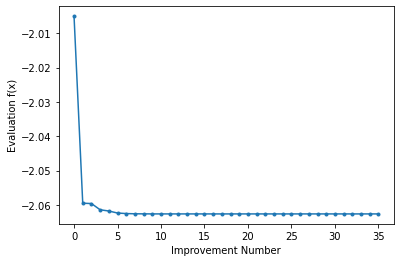

In [8]:
# Plot the learning curves
plt.plot(solution[2], '.-')
plt.xlabel('Improvement Number')
plt.ylabel('Evaluation f(x)')
plt.show()